# 大数据分析

## 第二次作业

__首先导入必要的库__

In [1]:
import math
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import os
from scipy import sparse 
from scipy.stats import norm
from numpy import *
import warnings
warnings.filterwarnings("ignore")

# 一、数据预处理
__数据通过pandas直接读入__    
__为了方便将数据做成矩阵，这里对用户ID做了一个映射，UID -> {0 - 9999}。同样，对电影的ID也做了映射 MID -> {0 - 9999}__    
__另外为了避免每次启动程序执行该过程，所以将映射完成之后的数据保存本地文件，下次可以直接读入__

In [2]:
#是否读取原始数据
F_netflix_test = 'netflix_test.csv'
F_netflix_train = 'netflix_train.csv'
F_users = 'users.csv'
F_movie_titles = 'movie_titles.csv'
F_users_T = 'users_T.csv'
if os.path.exists(F_netflix_test)==False \
    or os.path.exists(F_netflix_train)==False \
    or os.path.exists(F_users)==False \
    or os.path.exists(F_movie_titles)==False \
    or os.path.exists(F_users_T)==False:
    print '从原始数据读取并处理。'
    #数据读入
    df_file_test = pd.read_csv('netflix_test.txt' , sep=' ' , header = None , names = ['UID','MID','score','date'])
    df_file_train = pd.read_csv('netflix_train.txt' , sep=' ' , header = None , names = ['UID','MID','score','date'])
    df_file_users = pd.read_csv('users.txt' , sep=' ' , header = None , names = ['UID'])
    #用户INDEX与之用户ID的对应表，和df_file_users构成逆表关系，互查
    df_file_users_T = df_file_users[:]
    df_file_users_T = df_file_users_T.reset_index()
    df_file_users_T = df_file_users_T.set_index('UID')
    df_file_users_T.rename(columns = {'index':'UIDX'},inplace=True)
    #训练测试数据添加UIDX列保证UIDX取值范围控制再在0~9999之间
    df_file_train_UIDX = df_file_train['UID']
    df_file_test_UIDX = df_file_test['UID']
    for index in df_file_users_T.index.values:
        df_file_train_UIDX = df_file_train_UIDX.replace(index, int(df_file_users_T.loc[index,'UIDX']))
        df_file_test_UIDX = df_file_test_UIDX.replace(index, int(df_file_users_T.loc[index,'UIDX']))
    df_file_train['UIDX'] = df_file_train_UIDX
    df_file_test['UIDX'] = df_file_test_UIDX
    #训练测试数据添加MIDX列保证MIDX取值范围控制再在0~9999之间
    df_file_train['MIDX'] = df_file_train['MID'] - 1
    df_file_test['MIDX'] = df_file_test['MID'] - 1
    #保存
    df_file_test.to_csv(F_netflix_test)
    df_file_train.to_csv(F_netflix_train)
    df_file_users.to_csv(F_users)
    df_file_titles.to_csv(F_movie_titles)
    df_file_users_T.to_csv(F_users_T)
else:
    print '直接读取已有数据。'
    df_file_test = pd.read_csv(F_netflix_test)
    df_file_train = pd.read_csv(F_netflix_train)
    df_file_users = pd.read_csv(F_users)
    df_file_titles = pd.read_csv(F_movie_titles)
    df_file_users_T = pd.read_csv(F_users_T)
print '数据读入完成！'

直接读取已有数据。
数据读入完成！


__完成数据读入后，将数据看作稀疏矩阵数据装入（sparse.coo_matrix），然后直接张成一张完整的10000 * 10000的矩阵__    
__训练数据与测试结果数据相同处理方式，这一步得到矩阵X_train和X_test__

In [3]:
#创建训练和测试矩阵
row = df_file_train['UIDX'].values
col = df_file_train['MIDX'].values
data= df_file_train['score'].values
X_train = sparse.coo_matrix((data, (row, col)), shape=(10000, 10000)).toarray()
X_train = mat(X_train)
row = df_file_test['UIDX'].values
col = df_file_test['MIDX'].values
data= df_file_test['score'].values
X_test = sparse.coo_matrix((data, (row, col)), shape=(10000, 10000)).toarray()
X_test = mat(X_test)

__接下来生成训练矩阵和测试矩阵的标记矩阵__     
__另外本题采用均方根误差(Root Mean Square Error)作为推荐结果优劣的评价标准，在此定义了RMSE数值计算函数__   
_RMSE定义函数：_    
$$RMSE = \sqrt{\frac{1}{n}(\sum_{<i,j>\in Test}(X_{ij}-\hat X_{ij})^2)}$$
     
_实际矩阵运算函数算法：_    
$$N = (X \cdot \hat X_{sign} - \hat X)\cdot(X \cdot \hat X_{sign} - \hat X)$$
$$RMSE = \sqrt{\frac{\sum_{x_{ij}\in N} x_{ij}}{\sum_{x_{ij}\in \hat X} x_{ij}}}$$
_详见如下代码_

In [4]:
#求两个矩阵的标记矩阵
bool_train = np.sign(X_train)
bool_test = np.sign(X_test)
test_N_sqrt = np.sqrt(bool_test.sum())
def get_RMSE(pre_train):
    return np.linalg.norm(multiply(pre_train,bool_test) - X_test,'fro') / test_N_sqrt

# 二、协同过滤算法

__下面通过基于user的协同过滤的算法进行推荐，对于未知数据位置采取基于相似度加权的均值计算方案。__     
_首先，相似度函数采用向量余弦算法，下面是 i 用户和 k 用户打分相似的计算公式：_
$$sim(X_i,X_k) = cos(X_i,X_k) = \frac{X_i\cdot X_k}{\left|X_i\right| \cdot \left|X_k\right|}$$
_ i 用户对 j 电影打分算法：_
$$score(i,j)=\frac{\sum_k sim(X_i,X_k) \cdot score(k,j)}{\sum_k sim(X_i,X_k)}$$
     
__在矩阵条件下的算法逻辑和公式：__     
_首先计算构建用户间cos信息矩阵(设任意元素X（i，j）表示 i 用户与 j 用户的cos相关度)，然后计算目标结果_    
#### 1.将X每个行向量进行单位化
_约定： “$\cdot$” 是点乘; “$\div$” 是点除。_
$$X_m = X \div \sqrt{(X \cdot X)[1,1,...,1]^T}$$
#### 2.求取cos矩阵
$$X_{cos} = X_m X_m^T$$
#### 3.计算推荐矩阵
$$X_{pre} = \left(X_{cos}X\right) \div \left(X_{cos}X_{sign}\right)$$
    
__详见下面的代码以及执行结果__

In [5]:
all_begin = datetime.datetime.now()
#求各个列的模
mod_train = np.sqrt (multiply(X_train,X_train) * mat(np.ones((X_train.shape[0],1))))
#逐行单位化之后的向量
unit_train = np.nan_to_num(divide(X_train,mod_train))
#得到用户间cos关系矩阵
cos_train = unit_train * unit_train.T

#计算出所有预测结果
pre_train = np.nan_to_num(divide(cos_train * X_train,cos_train * bool_train))

all_end = datetime.datetime.now()

#计算RMSE
RMSE = get_RMSE(pre_train)

print 'RMSE= ' + str(RMSE)
print 'Time= ' + str(all_end - all_begin)

RMSE= 1.01910719672
Time= 0:01:30.269680


# 三、基于梯度下降算法的矩阵分解方案
__基本设计原理是将训练矩阵X分解为另外两个矩阵U V的乘积，依据偏导量不断修正U V的结果，最终逼近一个可靠值__     
__该部分不需要进行额外的矩阵运算推导，可以直接按照题目中给定的公式算法进行计算即可：__      
_目标函数：_
$$J = \frac12 {||A \circ(X-UV^T)||_{F}}^{2} + \lambda {||U||_F}^2 + \lambda {||V||_F}^2$$
_对UV矩阵求偏导：_
$$\frac{\partial J}{\partial U} = (A \circ (UV^T - X))V + 2\lambda U$$
$$\frac{\partial J}{\partial V} = (A \circ (UV^T - X))^T U + 2\lambda V$$
_每轮迭代公式：_
$$U = U - \alpha \frac{\partial J}{\partial U}$$
$$V = V - \alpha \frac{\partial J}{\partial V}$$
__对于U V矩阵的初始化问题，这里使用遵循标准正态分布的随机数进行填充。__     
__Frobenius范数、J值函数、偏导求解、UV递推公式以及梯度下降算法实现详细见下面的代码：__     

In [5]:
def Get_J(U,V,pre_train,ld):
    sub = multiply( bool_train , subtract( X_train , pre_train ) )
    step1 = np.linalg.norm(sub,'fro') / 2
    step2 = np.linalg.norm(U,'fro') * ld
    step3 = np.linalg.norm(V,'fro') * ld
    return step1 + step2 + step3

def Gradient_Decline_Get_RMSE_interval( k , af , ld , maxRounds,interval ):
    #按照正态分布，随机生成U、V
    m = X_train.shape[0]
    n = X_train.shape[1]
    U = mat(np.random.normal(size=m*k)).reshape(m,k)
    V = mat(np.random.normal(size=n*k)).reshape(n,k)
    #记录返回结果的list
    l_RMSE = []
    #最多循环次数
    for rounds in  range(maxRounds):
        #bujin
        temp = multiply( bool_train , U * V.T - X_train )
        U_new = U - ( af * (temp * V + 2 * ld * U) )
        V_new = V - ( af * (temp.T * U + 2 * ld * V) )
        U = U_new
        V = V_new
        if rounds % interval == 0:
            pre_train = U*V.T
            RMSE = get_RMSE(pre_train)
            l_RMSE.append(RMSE)
    return l_RMSE

#梯度下降算法
def Gradient_Decline_Get_Pre( k , af , ld , maxRounds ):
    #按照正态分布，随机生成U、V
    m = X_train.shape[0]
    n = X_train.shape[1]
    U = mat(np.random.normal(size=m*k)).reshape(m,k)
    V = mat(np.random.normal(size=n*k)).reshape(n,k)
    #记录返回结果的list
    l_J = []
    l_RMSE = []
    #最多循环次数
    for rounds in  range(maxRounds):
        #bujin
        temp = multiply( bool_train , U * V.T - X_train )
        U_new = U - ( af * (temp * V + 2 * ld * U) )
        V_new = V - ( af * (temp.T * U + 2 * ld * V) )
        U = U_new
        V = V_new
    return U , V

## 3.1 这里对$k = 50,\lambda = 0.01$进行分析
### 3.1.1 首先对$\alpha$的取值进行分析
_固定参数设定：$k = 50$ ; $\lambda = 0.01$ ; $测试轮数 = 150$_       
_测试参数$\alpha$分别取$0.00005,0.0001,0.00015,0.0002$进行梯度下降算法，并记录每一个阶段的RMSE数值，并画图显示：_    
     
__下面是执行代码以及工作结果:__

alpha = 5e-05 , min RMSE = 1.29263805199
alpha = 0.0001 , min RMSE = 1.1571900324
alpha = 0.00015 , min RMSE = 1.28087680436
alpha = 0.0002 , min RMSE = 2.07993252308


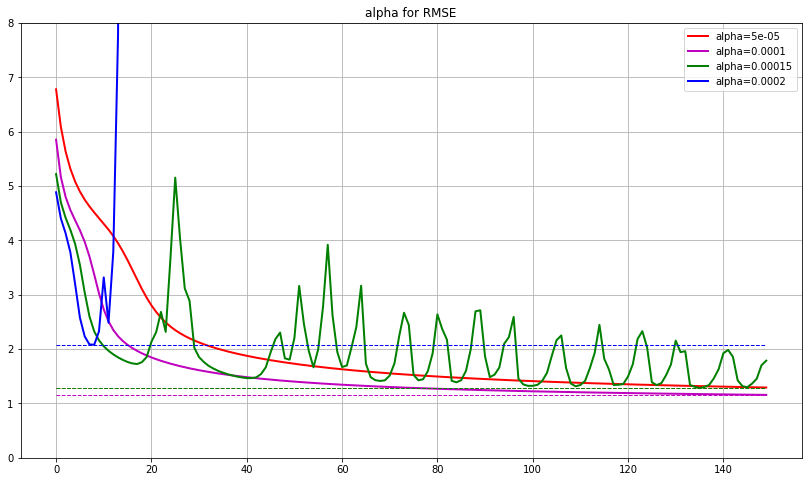

In [42]:
k  = 50
ld = 0.01
maxRounds = 150

plt.figure(figsize=(14,8))
for times , af in enumerate((0.00005,0.0001,0.00015,0.0002)):
    l_RMSE = Gradient_Decline_Get_RMSE_interval( k , af , ld ,maxRounds , 1 )
    minRMSE = min(l_RMSE)
    print 'alpha = '+str(af)+' , min RMSE = ' + str(minRMSE)
    plt.plot( range(0,maxRounds) , l_RMSE , 'rmgb'[times]+'-' , linewidth = 2 , label='alpha=' + str(af) )
    plt.plot( (0,maxRounds-1) , (minRMSE,minRMSE) , 'rmgb'[times]+'--' , linewidth = 1 )
plt.ylim(0,8)
plt.title('alpha for RMSE' )
plt.grid( True )
plt.legend()
plt.show()

__综合上述输出数据和图像我们得到如下观察结果：__    

|$\alpha$|最小RMSE|图形描述|
|-|
|0.00005|1.29263805199|图像逐步下降、过程平滑|
|0.0001|1.1571900324|图像逐步下降、过程平滑，更快速的下降到了更小的RMSE值|
|0.00015|1.28087680436|波动波动下降、振幅逐步减小|
|0.0002|2.07993252308|图像直接在10-20之间向上急速增大，波动比0.00015的情况更大|   

_综合上表结果： $\alpha=0.0001$ 相对于其他取值，它具有波动性小，过程平滑且RMSE下降速度快的优点，故后面实验按照0.0001的取值进行。_   

### 3.1.2 $k = 50,\lambda = 0.01$下的取值结果
_对于上述实验结果可以看出当轮数继续增大的情况下，RMSE可以取到更小值，对于上述150轮迭代结果可以得到的最好RMSE结果为1.1571900324，后面的实验会再次讨论到这个问题。_    


## 3.2 $k$ 和 $\lambda$ 参数组合选优
### 3.2.1 参数设定：
固定参数:     
$\alpha = 0.0001$   
实验轮数 400轮
组合变动参数:    
$k = 20 , 50$      
$\lambda = 0.1 , 0.01 , 0.001$
### 3.2.2 数据输出：
_对6组参数进行实验，每隔9轮次取一次RMSE数据进行统计_      
__下面先进行数据收集:__

In [55]:
af = 0.0001
maxRounds = 400
interval = 10
d_RMSE = {}
for k in (20,50):
    for ld in (0.1,0.01,0.001):
        d_RMSE[str(k)+'_'+str(ld)] = Gradient_Decline_Get_RMSE_interval( k , af , ld ,maxRounds,interval )
        print("k = %d , lambda = %f ..... ok!"%(k,ld))

k = 20 , lambda = 0.100000 ..... ok!
k = 20 , lambda = 0.010000 ..... ok!
k = 20 , lambda = 0.001000 ..... ok!
k = 50 , lambda = 0.100000 ..... ok!
k = 50 , lambda = 0.010000 ..... ok!
k = 50 , lambda = 0.001000 ..... ok!


### 3.2.3 统计结果呈现分析：
_计算每组的最小RMSE取值，并将获得的RMSE绘制在统一张表中进行分析讨论。_     
__下面是数据展现代码运行：__

( k , lambda ) = ( 20 , 0.1 )	 min RMSE = 0.966908023558
( k , lambda ) = ( 20 , 0.01 )	 min RMSE = 0.982287455746
( k , lambda ) = ( 20 , 0.001 )	 min RMSE = 0.969586197976
( k , lambda ) = ( 50 , 0.1 )	 min RMSE = 1.08771825876
( k , lambda ) = ( 50 , 0.01 )	 min RMSE = 1.0858126907
( k , lambda ) = ( 50 , 0.001 )	 min RMSE = 1.08691949245


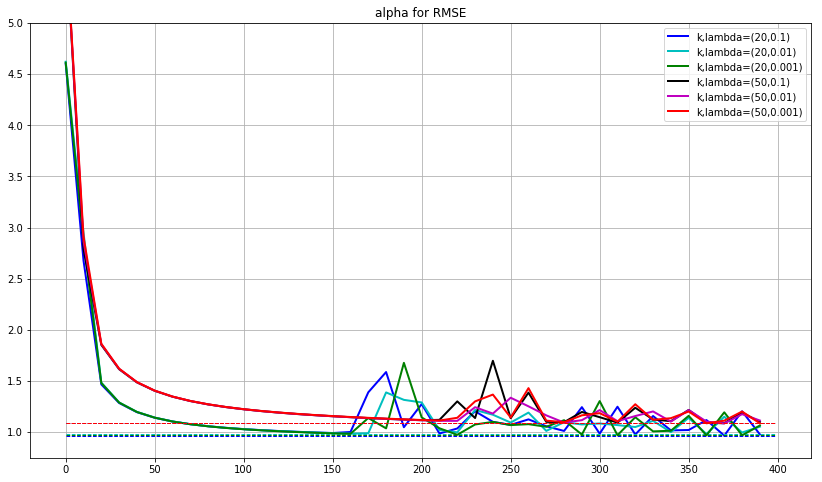

In [68]:
times = 0
plt.figure(figsize=(14,8))
for k in (20,50):
    for ld in (0.1,0.01,0.001):
        l_RMSE = d_RMSE[str(k)+'_'+str(ld)]
        plt.plot( range(0,maxRounds,interval) , l_RMSE , 'bcgkmry'[times]+'-' , linewidth = 2 , label='k,lambda=('+str(k)+','+str(ld)+')' )
        plt.plot( (0,maxRounds-1) , (min(l_RMSE),min(l_RMSE)) , 'bcgkmry'[times]+'--' , linewidth = 1 )
        times += 1
        print '( k , lambda ) = ( ' + str(k) + ' , ' + str(ld) + ' )\t min RMSE = ' + str(min(l_RMSE))
plt.ylim(0.75,5)
plt.title('alpha for RMSE' )
plt.grid( True )
plt.legend()
plt.show()

__通过上面的图、表可以得到以下讨论结果：__    
_$k$的取值对结果的影响更加明显，在相同运算轮次的条件下，$k=20$得到的RMSE更小。但$\lambda$对结果的影响并不明显。_    

### 3.2.4 运算速度分析：
__对各组合进行1000轮运行测试，记录最后一次之后的RMSE和各组运行时间：__

In [7]:
af = 0.0001
maxRounds = 1000
for k in (20,50):
    for ld in (0.1,0.01,0.001):
        np.random.seed(8888)
        tbegin = datetime.datetime.now()
        U , V = Gradient_Decline_Get_Pre( k , af , ld ,maxRounds )
        tend = datetime.datetime.now()
        RMSE = get_RMSE( U * V.T )
        print("k = %d , lambda = %f , RMSE = %f , Time = %d..... ok!"%(k,ld,RMSE,(tend-tbegin).total_seconds()))

k = 20 , lambda = 0.100000 , RMSE = 0.931565 , Time = 2268..... ok!
k = 20 , lambda = 0.010000 , RMSE = 0.940415 , Time = 1933..... ok!
k = 20 , lambda = 0.001000 , RMSE = 0.941345 , Time = 1978..... ok!
k = 50 , lambda = 0.100000 , RMSE = 1.013602 , Time = 2173..... ok!
k = 50 , lambda = 0.010000 , RMSE = 1.022619 , Time = 2116..... ok!
k = 50 , lambda = 0.001000 , RMSE = 1.023630 , Time = 2128..... ok!


_从上述时间结果可以得出结论，一般情况下，$k = 20$要稍微优于$k = 50$_    
_另外可以得到结论：_     
_大约平均每一轮迭代需要消耗2秒左右的时间。_     

     
__经过上述讨论，本题目参数确定选取：__    
__$$k = 20,\lambda = 0.1,\alpha = 0.0001$$__

# 四、两种方案对比
## 4.1 时间损耗讨论
__这里再补充一个达到同等RMSE结果时，两种算法所消耗的时间损耗的比对计算：__     
__通过第二节里的实验结果，得知协同过滤的时间消耗为90秒，达到的RMSE为1.01910719672。__     
__通过第三节里的实验结果，得知在$k = 20,\lambda = 0.1,\alpha = 0.0001$条件下梯度下降算法每一轮的时间消耗为$2268 / 1000$。__     
__这里计算$k = 20,\lambda = 0.1,\alpha = 0.0001$参数下300轮的RMSE取值，然后寻找第一个出现比1.01910719672小的轮次来估算等同结论条件下的时间消耗：__

In [13]:
ListRMSE = Gradient_Decline_Get_RMSE_interval( 20 , 0.0001 , 0.1 ,300, 1 )
GDIndex = 0
for index in range(len(ListRMSE)):
    if ListRMSE[index] < 1.01910719672:
        GDIndex = index
        break
preTimes = GDIndex * (2268 / 1000)
print 'Rounds = ' + str(GDIndex) + ' ; Times = ' + str(preTimes) + ' s'

Rounds = 110 ; Times = 220 s


__结果梯度下降在第110轮出现等同效率结果RMSE，估算时间损耗为220秒(注：这里还没有包含计算J值的时间)。__     
__从时间损耗来看，同等结果条件下协同过滤具有更好的时间优势,本例中为90秒。__     

## 4.2 可达到最佳结果
__通过前面的实验可以知道，协同过滤得到RMSE为1.01910719672。__    
__而梯度下降算法在110轮后达到了更小值，在1000轮时达到0.931565，通过合理设置J值并让程序继续运行下去获取可以取得更好的结果。__
       
## 4.3 空间损耗
__矩阵分解算法具有比较低的空间复杂度，将一个很大的矩阵运算问题转化为求解两个较小的矩阵的乘积问题，且通过不断的迭代，使结果更加趋近于一个理想的结果，同时也具有较好的可拓展性。而协同过滤算法则不得不一次性消耗较大的运算空间来解决大矩阵的存储和运算的问题，尤其是矩阵乘操作，当实际数据足够大足够复杂的情况下，协同过滤则显得捉襟见肘，不得不依赖更好的硬件环境支持或是考虑选取局部数据进行运算。__

## 4.4 其他
>__a. 矩阵分解算法最终得到的U矩阵和V矩阵不具有很好的可解释性。因为把评分矩阵分解成user-factor矩阵和item-factor矩阵，这里的factor很难用实际意义的概念来解释。但是协同过滤算法就不存在这个问题。__        
>__b. 在时间损耗可以接受的情况下，矩阵分解算法具有较小的空间复杂度，而且更加灵活，扩展性强，通过合理设置J值可以在时间和最优解之间灵活折衷调整。__